In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from shapely.geometry import Point
import sys
sys.path.insert(1, '../')
from PlottingFunctions import *
cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

## Get geodatframe of Manchester LSOAs, filer our just a central ring

In [3]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]

### Get gentrification index, create categorical version

In [4]:
def gi_cat(row):
   if row['gi_n'] < 25 :
      return 0
   if row['gi_n'] >= 25 and row['gi_n'] <= 50 :
      return 1
   if row['gi_n'] >= 50 and row['gi_n'] <= 75 :
      return 2
   if row['gi_n'] >= 75 and row['gi_n'] <= 100 :
      return 3

In [5]:
g_index = pd.read_csv("../../../data/GentrificationIndex/ManchesterIndex/manc_index.csv") 
g_index_df = g_index.merge(central_lsoas[['LSOA11NM', 'geometry']], on='LSOA11NM', how='left')
g_index_gdf = gpd.GeoDataFrame(g_index_df, geometry='geometry', crs="EPSG:27700")
g_index_gdf['gi_n_categorical'] = g_index_gdf.apply(gi_cat, axis=1)
# g_index_gdf['gi_n_categorical2'] = lsoa_scores

In [6]:
# # fig,ax=plt.subplots(figsize=(6,5), constrained_layout=True)
# # plt.hist(g_index_gdf['gi_n'], bins=100, color='green');
# # ax.set_ylim(0, 80) 
# # plt.xlabel('Gentrification Index', fontsize=15);
# # plt.ylabel('Number of LSOAs', fontsize=15)
# # plt.title('(a) Manchester', fontsize=20, fontweight = 'bold');
# # # plt.tight_layout()
# # fig.savefig("../Figures/Manchester_Barplot_GI.png", bbox_inches='tight', pad_inches=3)

# fig, ax = plt.subplots(figsize=(6,9), constrained_layout=False)
# ax.hist(g_index_gdf['gi_n'], bins=100, color='green')
# ax.set_ylim(0, 80) 
# ax.set_xlabel('Gentrification Index', fontsize=15)
# ax.set_ylabel('Number of LSOAs', fontsize=15)
# ax.set_title('(a) Manchester', fontsize=20, fontweight='bold')

# # Add extra space only at bottom (fraction of figure height)
# fig.subplots_adjust(bottom=0.5)  

# fig.savefig("../Figures/Manchester_Barplot_GI.png", dpi=300)


### Plot gentrification index, continuous and categorical

In [7]:
# np.unique(g_index_gdf['gi_n_categorical'] ==  g_index_gdf["gi_n_categorical2"])

KeyError: 'gi_n_categorical2'

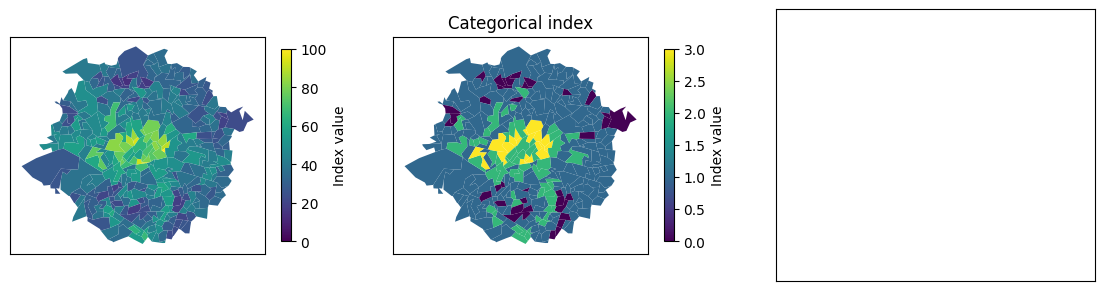

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]}) 
for i in range(0,3):
    axs[i].tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
g_index_gdf.plot(ax = axs[0],column =  "gi_n" , legend=True,  legend_kwds={'shrink': 0.5, 'label': "Index value", 'orientation': 'vertical'});
# axs[0].set_title('Continuous index')
g_index_gdf.plot(ax = axs[1],column =  "gi_n_categorical",  legend=True, legend_kwds={'shrink': 0.5, 'label': "Index value", 'orientation': 'vertical'})
axs[1].set_title('Categorical index')
g_index_gdf.plot(ax = axs[2],column =  "gi_n_categorical2", legend=True, legend_kwds={'shrink': 0.5, 'label': "Index value", 'orientation': 'vertical'}); # theses are all the same
axs[2].set_title('Categorical index (method 2)');
axs[2].legend()

### Find the average gentrification category in each LSOA

In [13]:
lsoa_scores = pd.DataFrame({'score': g_index_gdf.groupby("LSOA11CD")["gi_n_categorical"].agg(lambda x: pd.Series.mode(x).iloc[0]), 
              'count':g_index_gdf.groupby("LSOA11CD")["gi_n_categorical"].count()})
lsoa_scores.reset_index(inplace=True)

In [113]:
indicators_manchester = indicators_manchester.merge(lsoa_scores, on='LSOA11CD', how='right')
indicators_manchester.sort_values(by='score', inplace=True)
del indicators_manchester['geometry']

### Alternative method

In [15]:
lsoa_scores = pd.DataFrame({'gi_n': g_index_gdf.groupby("LSOA11CD")["gi_n"].agg(lambda x: pd.Series.mean(x)), 
              'count':g_index_gdf.groupby("LSOA11CD")["gi_n"].count()})
lsoa_scores.reset_index(inplace=True)
lsoa_scores = lsoa_scores.apply(gi_cat, axis=1)

## Plot Rose plots for gentrification index categories
#### Scale the indicators

In [115]:
numeric_cols = indicators_manchester.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'score', 'count'])

standard_scaler = StandardScaler()
scaled_standard = standard_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
indicators_manchester_standard = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'score', 'count']], scaled_standard_df], axis=1)

In [125]:
mapping = {'0-25': 0,'25-50': 1, '50-75': 2, '75-100': 3,}

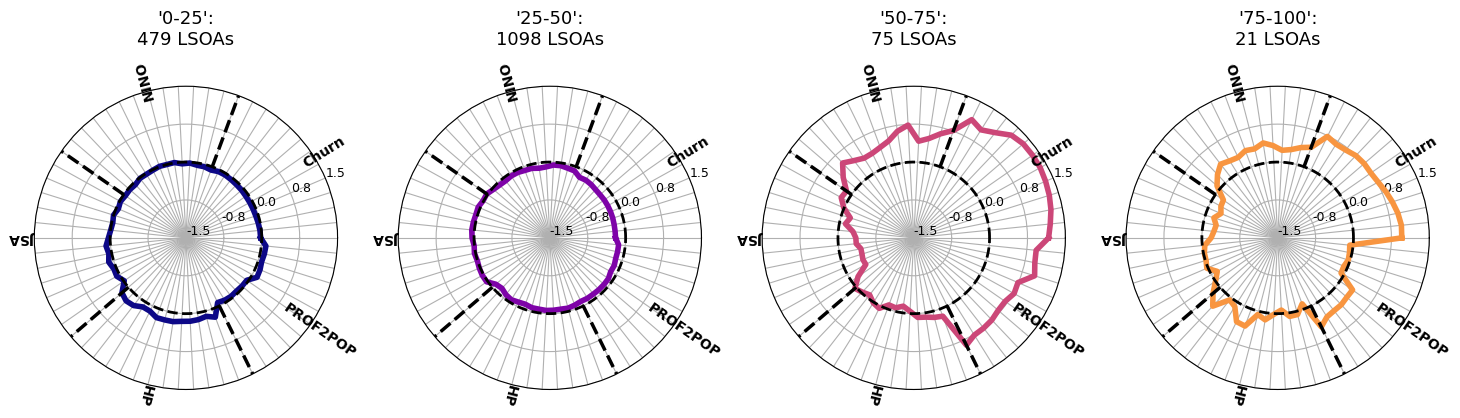

In [130]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=4, nrows=1, figsize=(18, 8), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_manchester_standard[
        indicators_manchester_standard['score'] == gentr_class]
    if class_data.empty:
        ax.set_axis_off()
    else:
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        plot_flexible_radar( ax, class_data, numeric_cols,
            color=plot_colors[gentr_class],  title=f"'{key}':\n{len(class_data)} LSOAs", show_std=False, fixed_max=1.5)
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=2, linestyle='dashed')

### Socio-economic indicators

In [8]:
indicators = pd.read_csv("../../data/GentrificationIndex/SocioEconomicData/Eng_imputedV3.csv") # for the whole o England
# Get just for Manchester
indicators_manchester = indicators[indicators['LA_NAME'].str.contains(manc_lads_pattern)].copy()
indicators_manchester = indicators_manchester.rename(columns={"LSOA": 'LSOA11CD'})
del indicators_manchester['Churn_2020']
indicators_manchester.reset_index(inplace=True, drop=True)

indicators_manchester = indicators_manchester.merge(central_lsoas[['LSOA11CD', 'geometry']], on='LSOA11CD', how='right')
indicators_manchester_gdf = gpd.GeoDataFrame(indicators_manchester, geometry='geometry', crs="EPSG:27700")

In [9]:
churn_cols = [f"Churn_{year}" for year in range(2008, 2020)]
NINO_cols = [f"NINO_{year}" for year in range(2008, 2021)]
JSA_cols = [f"JSA_{year}" for year in range(2008, 2021)]
HP_cols = [f"HP_{year}" for year in range(2008, 2021)]
PROF2POP_cols = [f"HP_{year}" for year in range(2010, 2021)]

indicators_manchester_gdf_means = pd.DataFrame({'Churn_mean':indicators_manchester_gdf[churn_cols].mean(axis=1),
                                               'NINO_mean':indicators_manchester_gdf[NINO_cols].mean(axis=1),
                                                'JSA_mean':indicators_manchester_gdf[JSA_cols].mean(axis=1),
                                                'HP_mean':indicators_manchester_gdf[HP_cols].mean(axis=1),
                                                'PROF2POP_mean':indicators_manchester_gdf[PROF2POP_cols].mean(axis=1),
                                                'geometry':indicators_manchester_gdf['geometry']
                                               })
indicators_manchester_gdf_means = gpd.GeoDataFrame(indicators_manchester_gdf_means, geometry='geometry', crs="EPSG:27700")

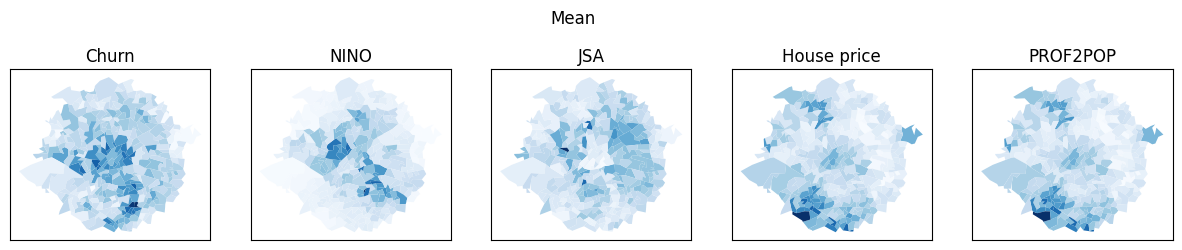

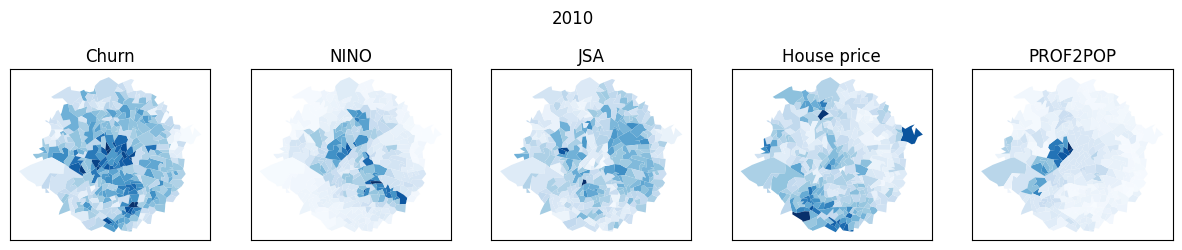

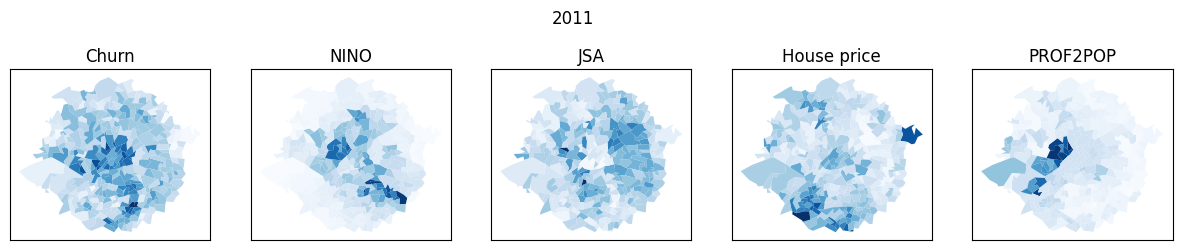

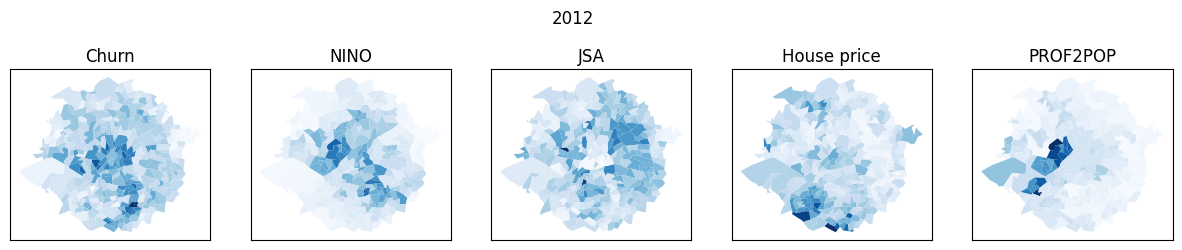

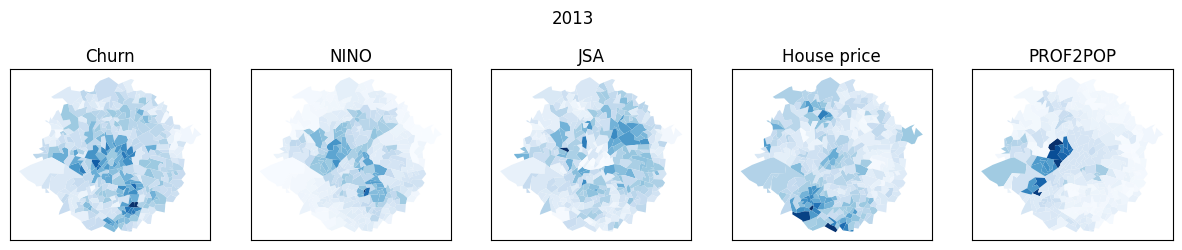

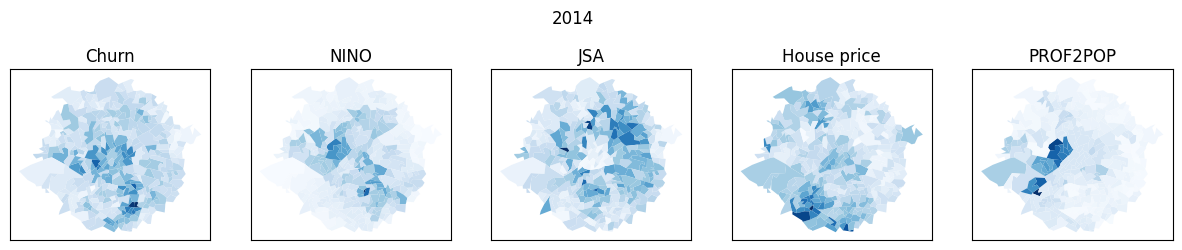

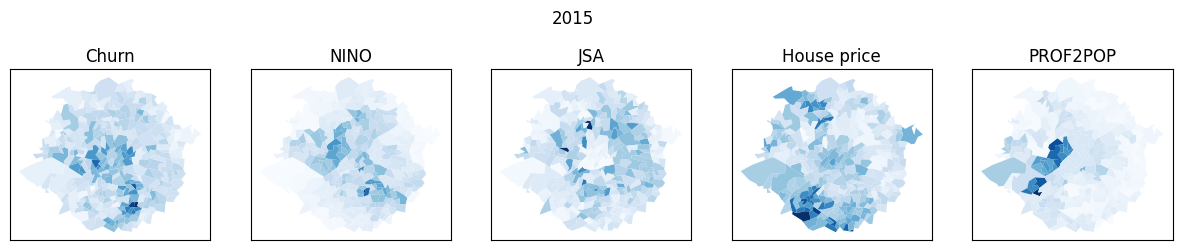

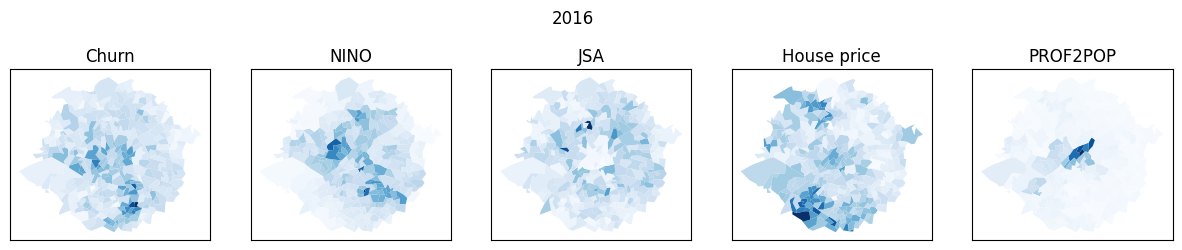

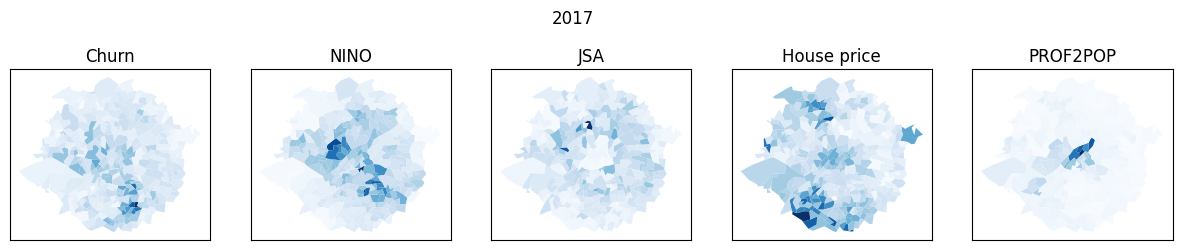

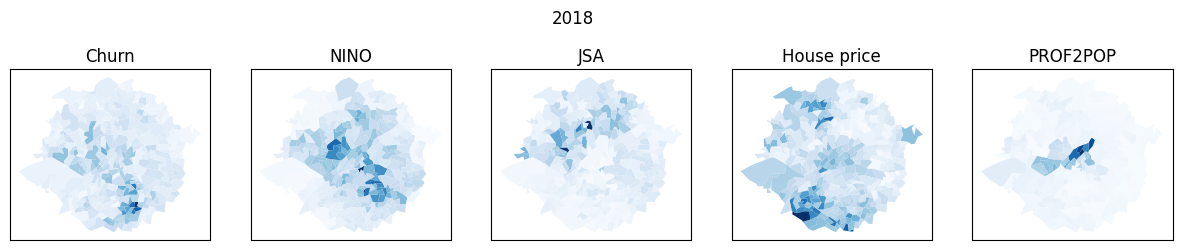

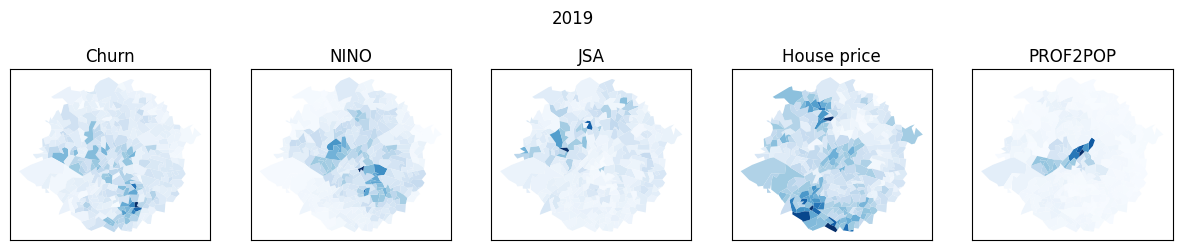

In [10]:
fig , axs=plt.subplots(ncols=5, figsize=(15,3), sharey=True, sharex=True)
indicators_manchester_gdf_means.plot(ax = axs[0], column = "Churn_mean", cmap = 'Blues')
axs[0].set_title("Churn")
indicators_manchester_gdf_means.plot(ax = axs[1], column = "NINO_mean", cmap = 'Blues')
axs[1].set_title("NINO")
indicators_manchester_gdf_means.plot(ax = axs[2], column = "JSA_mean", cmap = 'Blues')
axs[2].set_title("JSA")
indicators_manchester_gdf_means.plot(ax = axs[3], column = "HP_mean", cmap = 'Blues')
axs[3].set_title("House price")
indicators_manchester_gdf_means.plot(ax = axs[4], column = "PROF2POP_mean", cmap = 'Blues')
axs[4].set_title("PROF2POP")

for i in range(0,5):
    axs[i].tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
fig.suptitle("Mean")


def plot_for_year (year):
    fig , axs=plt.subplots(ncols=5, figsize=(15,3), sharey=True, sharex=True)
    indicators_manchester_gdf.plot(ax = axs[0], column = f"Churn_{year}", cmap = 'Blues')
    axs[0].set_title("Churn")
    indicators_manchester_gdf.plot(ax = axs[1], column = f"NINO_{year}", cmap = 'Blues')
    axs[1].set_title("NINO")
    indicators_manchester_gdf.plot(ax = axs[2], column = f"JSA_{year}", cmap = 'Blues')
    axs[2].set_title("JSA")
    indicators_manchester_gdf.plot(ax = axs[3], column = f"HP_{year}", cmap = 'Blues')
    axs[3].set_title("House price")
    indicators_manchester_gdf.plot(ax = axs[4], column = f"PROF2POP_{year}", cmap = 'Blues')
    axs[4].set_title("PROF2POP")
    
    for i in range(0,5):
        axs[i].tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
    fig.suptitle(year)
    
for year in range(2010,2020):
    plot_for_year(year)       